In [ ]:
%%capture
!pip install fastai

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from fastai.text.all import *

In [ ]:
class Config:
    BASE_DIR = Path('/content/drive/MyDrive/College/machine_learning_2/submissions/1')
    DATA_DIR = BASE_DIR / 'datasets'
    MODEL_DIR = BASE_DIR / 'models'
    RESULT_DIR = BASE_DIR / 'results'

In [ ]:
df_train = pd.read_csv(Config.DATA_DIR / '20newsgroup_train_preprocessed.csv', index_col='Unnamed: 0')
df_valid = pd.read_csv(Config.DATA_DIR / '20newsgroup_valid_preprocessed.csv', index_col='Unnamed: 0')
df_test = pd.read_csv(Config.DATA_DIR / '20newsgroup_test_preprocessed.csv', index_col='Unnamed: 0')
df_train.head()

,content,target,email,subject,content_cleaned
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or wha...",7,lerxst@wam.umd.edu,WHAT car is this,from wheres my thing subject what car be this nntppostinghost racwamumdedu organization university of maryland college park line i be wonder if anyone out there could enlighten me on this car i saw the other day it be a door sport car look to be from the late s early s it be call a bricklin the doors be really small in addition the front bumper be separate from the rest of the body this be all i know if anyone can tellme a model name engine specs years of production where this car be make history or whatever info you have on this funky look car please email thank il bring to you by your ne...
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, flopp...",4,guykuo@carson.u.washington.edu,SI Clock Poll Final Call,from guy kuo subject si clock poll final call summary final call for si clock report keywords siaccelerationclockupgrade articleid shelleyforincs organization university of washington line nntppostinghost carsonuwashingtonedu a fair number of brave souls who upgrade their si clock oscillator have share their experience for this poll please send a brief message detail your experience with the procedure top speed attain cpu rat speed add on card and adapters heat sink hour of usage per day floppy disk functionality with and m floppies be especially request i will be summarize in the next two...
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd ...",4,twillis@ec.ecn.purdue.edu,PB questions,from thomas e willis subject pb question organization purdue university engineer computer network distribution usa line well folks my mac plus finally give up the ghost this weekend after start life as a k way back in sooo im in the market for a new machine a bite sooner than i intend to be im look into pick up a powerbook or maybe and have a bunch of question that hopefully somebody can answer do anybody know any dirt on when the next round of powerbook introductions be expect id hear the c be suppose to make an appearance this summer but havent hear anymore on it and since i dont have ac...
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN 

In [ ]:
def clean_text(text):
    # Remove email headers (anything starting with "From:", "Subject:", etc.)
    text = re.sub(r'From:.*\n', '', text)
    text = re.sub(r'Subject:.*\n', '', text)
    text = re.sub(r'Organization:.*\n', '', text)
    text = re.sub(r'Distribution:.*\n', '', text)
    text = re.sub(r'Lines:.*\n', '', text)
    text = re.sub(r'>+', '', text)  # Remove quotation marks (often used in replies)

    # Remove email addresses and URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remove email addresses
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs

    # Remove numbers, hyphens, and underscores
    text = re.sub(r'[\d_-]', '', text)  # Remove digits, hyphens, and underscores

    # Remove extra whitespace, including newline characters
    text = re.sub(r'\n+', ' ', text)  # Replace multiple newlines with a space
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space

    # Remove any non-alphanumeric characters except for common punctuation
    text = re.sub(r'[^A-Za-z\s.,!?\'"-]', '', text)

    # Convert to lowercase (optional, based on your dataset)
    text = text.lower()

    return text.strip()

In [ ]:
df_train['content_cleaned'] = df_train['content'].apply(clean_text)
df_train.head()

,content,target,email,subject,content_cleaned
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or wha...",7,lerxst@wam.umd.edu,WHAT car is this,"nntppostinghost rac.wam.umd.edu i was wondering if anyone out there could enlighten me on this car i saw the other day. it was a door sports car, looked to be from the late s early s. it was called a bricklin. the doors were really small. in addition, the front bumper was separate from the rest of the body. this is all i know. if anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please email. thanks, il brought to you by your neighborhood lerxst"
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, flopp...",4,guykuo@carson.u.washington.edu,SI Clock Poll Final Call,"summary final call for si clock reports keywords si,acceleration,clock,upgrade articlei.d. shelley.qvfoinncs nntppostinghost carson.u.washington.edu a fair number of brave souls who upgraded their si clock oscillator have shared their experiences for this poll. please send a brief message detailing your experiences with the procedure. top speed attained, cpu rated speed, add on cards and adapters, heat sinks, hour of usage per day, floppy disk functionality with and . m floppies are especially requested. i will be summarizing in the next two days, so please add to the network knowledge bas..."
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd ...",4,twillis@ec.ecn.purdue.edu,PB questions,"well folks, my mac plus finally gave up the ghost this weekend after starting life as a k way back in . sooo, i'm in the market for a new machine a bit sooner than i intended to be... i'm looking into picking up a powerbook or maybe and have a bunch of questions that hopefully somebody can answer does anybody know any dirt on when the next round of powerbook introductions are expected? i'd heard the c was supposed to make an appearence ""this summer"" but haven't heard anymore on it and since i don't have access to macleak, i was wondering if anybody out there had more info... has anybody ..."
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (

In [ ]:
df_valid['content_cleaned'] = df_valid['content'].apply(clean_text)
df_test['content_cleaned'] = df_test['content'].apply(clean_text)

In [ ]:
# Define hyperparameters
SEQ_LEN = 80
BS = 32
LR = 2e-2
EPOCHS = 6
WEIGHT_DECAY = 0.1
DROPOUT=0.3

In [ ]:
# Define the DataLoaders
text_dls = TextDataLoaders.from_df(
    df_train, valid_df=df_valid, text_col='content_cleaned', label_col='target', seq_len=SEQ_LEN, bs=BS
)

In [ ]:
# Load a pretrained AWD-LSTM language model and fine-tune it
learn = text_classifier_learner(
    text_dls, AWD_LSTM, metrics=[accuracy, F1Score(average='macro')],
    wd=WEIGHT_DECAY, drop_mult=DROPOUT
)

/usr/local/lib/python3.11/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

/usr/local/lib/python3.11/dist-packages/fastai/text/learner.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device)


SuggestedLRs(valley=0.0030199517495930195)

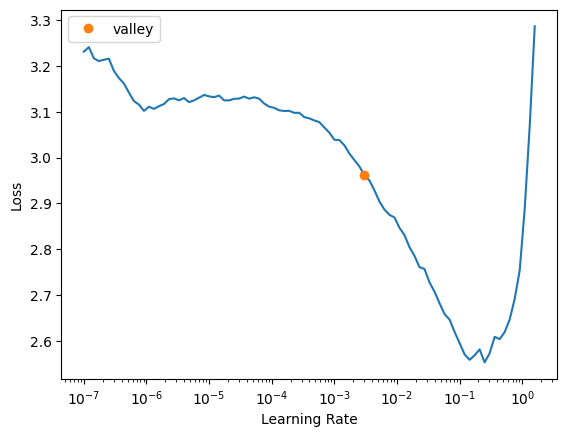

In [ ]:
# Find optimal learning rate
learn.lr_find()

In [ ]:
LR = 5e-3

In [ ]:
# Fine-tune the model
learn.fine_tune(EPOCHS, base_lr=LR)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.719884,1.380300,0.569408,0.549329,01:16


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.204636,1.037180,0.667109,0.647342,02:27
1,1.040834,0.966689,0.687887,0.683099,02:28
2,0.721613,0.859623,0.734306,0.728396,02:27
3,0.456827,0.749608,0.775420,0.771566,02:28
4,0.266657,0.739070,0.780283,0.777675,02:28
5,0.200671,0.754322,0.778515,0.776380,02:28


In [ ]:
# Evaluate on validation set
preds, targs = learn.get_preds()
preds = preds.argmax(dim=1)

In [ ]:
preds

tensor([ 9, 12,  8,  ..., 17,  2,  7])

In [ ]:
targs

tensor([ 9,  2,  8,  ..., 17,  2,  7])

In [ ]:
preds = preds.numpy()
targs = targs.numpy()

In [ ]:
AWD_LSTM_results = {
    "Model": "AWD_LSTM",
    "Embedding": "AWD_LSTM",
    "Accuracy": accuracy_score(targs, preds),
    "F1 Score": f1_score(targs, preds, average='weighted'),
    "Precision": precision_score(targs, preds, average='weighted'),
    "Recall": recall_score(targs, preds, average='weighted')
}
AWD_LSTM_results

{'Model': 'AWD_LSTM',
 'Embedding': 'AWD_LSTM',
 'Accuracy': 0.7785145888594165,
 'F1 Score': 0.7828047963354756,
 'Precision': 0.7949499614402067,
 'Recall': 0.7785145888594165}

In [ ]:
all_results = pd.read_csv(Config.RESULT_DIR / 'results.csv', index_col='Unnamed: 0')
all_results.head()

,Model,Accuracy,Precision,Recall,F1 Score,Embedding
0,SVM,0.749071,0.760012,0.749071,0.750662,tf_idf
1,Logistic Regression,0.744822,0.748750,0.744822,0.743840,tf_idf
2,Multinomial Naive Bayes,0.740308,0.755364,0.740308,0.734480,tf_idf
3,Multinomial Naive Bayes,0.712161,0.725300,0.712161,0.712840,bow
4,SVM,0.691450,0.693950,0.691450,0.686917,word2vec


In [ ]:
# Append AWD_LSTM_results to all_results DataFrame
all_results = pd.concat([all_results, pd.DataFrame([AWD_LSTM_results])], ignore_index=True)
all_results = all_results.sort_values(by='F1 Score', ascending=False)
all_results

,Model,Accuracy,Precision,Recall,F1 Score,Embedding
25,AWD_LSTM,0.778515,0.794950,0.778515,0.782805,AWD_LSTM
0,SVM,0.749071,0.760012,0.749071,0.750662,tf_idf
1,Logistic Regression,0.744822,0.748750,0.744822,0.743840,tf_idf
2,Multinomial Naive Bayes,0.740308,0.755364,0.740308,0.734480,tf_idf
3,Multinomial Naive Bayes,0.712161,0.725300,0.712161,0.712840,bow
4,SVM,0.691450,0.693950,0.691450,0.686917,word2vec
5,Logistic Regression,0.685608,0.691856,0.685608,0.686694,bow
6,LSTM,0.681891,0.676822,0.681891,0.676617,word2vec
7,Logistic Regression,0.668879,0.660275,0.668879,0.657294,word2vec
8,Logistic Regression,0.649495,0.644230,0.649495,0.643579,glove


In [ ]:
all_results.to_csv(Config.RESULT_DIR / 'results.csv')

In [ ]:
# Combine df_train and df_valid for final training
df_final_train = pd.concat([df_train, df_valid])

In [ ]:
# Create new DataLoaders with the combined data
text_dls_final = TextDataLoaders.from_df(
    df_final_train, valid_df=df_test, text_col='content_cleaned', label_col='target', seq_len=SEQ_LEN, bs=BS
)

In [ ]:
# Retrain the model
learn = text_classifier_learner(
    text_dls_final, AWD_LSTM, metrics=[accuracy, F1Score(average='macro')],
    wd=0.1, drop_mult=0.3
)
learn.fine_tune(EPOCHS, base_lr=LR)

/usr/local/lib/python3.11/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.659100,1.409497,0.552719,0.530830,01:43


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.183019,0.996566,0.680371,0.659558,03:17
1,0.978689,0.946992,0.681366,0.671833,03:17
2,0.713646,0.779583,0.757958,0.749928,03:16
3,0.459262,0.712906,0.783820,0.779254,03:16
4,0.311545,0.717698,0.792109,0.788956,03:17
5,0.214633,0.694547,0.796419,0.789964,03:17


In [ ]:
learn.model.eval()

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(40400, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(40400, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0-2): 3 x RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.12, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)
      )
      (1): LinBnDrop(
        (0): 

In [ ]:
# Use the same DataLoader for the test set (this uses the same preprocessing pipeline)
test_dl = learn.dls.test_dl(df_test['content_cleaned'].tolist())

# Get predictions
preds, _ = learn.get_preds(dl=test_dl)

# Convert predictions to class labels (indices of the class)
pred_labels = preds.argmax(dim=1)

# The true labels (targs) are already integers as you've stated
targs = df_test['target'].tolist()

In [ ]:
# Compute metrics
AWD_LSTM_results_final = {
    "Model": "AWD_LSTM",
    "Embedding": "AWD_LSTM",
    "Accuracy": accuracy_score(targs, pred_labels),
    "F1 Score": f1_score(targs, pred_labels, average='weighted'),
    "Precision": precision_score(targs, pred_labels, average='weighted'),
    "Recall": recall_score(targs, pred_labels, average='weighted')
}

AWD_LSTM_results_final

{'Model': 'AWD_LSTM',
 'Embedding': 'AWD_LSTM',
 'Accuracy': 0.7793414763674986,
 'F1 Score': 0.7793027343806258,
 'Precision': 0.7833568732375406,
 'Recall': 0.7793414763674986}

In [ ]:
# Save the learner(the model and the dataloader)
learn.export(Config.MODEL_DIR / "aws_lstm_model.pkl")

In [ ]:
# Load the saved model and DataLoader
loaded_learner = load_learner(Config.MODEL_DIR / "aws_lstm_model.pkl")

In [ ]:
example_text = df_test['content_cleaned'].iloc[1]

In [ ]:
preds= loaded_learner.predict(example_text)

In [ ]:
np.argmax(preds[2].numpy())

11

In [ ]:
df_test['target'].iloc[1]

11